# Speech Emotion Detection

In [73]:
import librosa
import soundfile
import os, glob
import numpy as np
import soundfile
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv1D, BatchNormalization, Activation, MaxPooling2D, MaxPooling1D, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.display import Audio
import tensorflow as tf

In [90]:
def extract(filepath, mfcc, chroma, mel):
    try:
        y,sr = librosa.load(filepath, duration=2.5)
        #sample_rate=22050
        result = np.array([])
        stft = np.abs(librosa.stft(y))
        if mfcc:
            mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfcc))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
            result = np.hstack((result, mel))
        return result
    
    except Exception as e:
        print(f"Error processing {filepath}:e")
        return np.array([])

emotions = {
    "01":"neutral",
    "02":"calm",
    "03":'happy',
    "04":"sad",
    "05":'angry',
    '06':'fearful',
    '07':'disgust',
    "08":'surprised'
}

observed_emotions = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']


In [91]:
def load_data(test_size=0.25):
    x,y1 = [],[]
    for file in glob.glob("C:/Users/Shuaib/Desktop/ML Internship/Task-1/Speech Emotion Detection/audio_speech_actors_01-24/Actor_*/*.wav"):
        filename = os.path.basename(file)
        emotion = emotions[filename.split("-")[2]]
        if emotion not in observed_emotions:
            continue

        feature = extract(file, mfcc=True, chroma=True, mel=True)
        #padded_features = pad_sequences(feature, padding='post')
        x.append(feature)
        y1.append(emotion)
    return train_test_split(np.array(x),y1, test_size=test_size, random_state=9)

In [92]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [93]:
x_train_padded = pad_sequences(x_train, padding='post',dtype='float32')
x_test_padded = pad_sequences(x_test, padding='post',dtype='float32')

In [128]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)
    return x

In [129]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [137]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, 3)
    conv_2 = Convolution(conv_1, 128, 5)
    conv_3 = Convolution(conv_2, 512, 3)
    conv_4 = Convolution(conv_3, 512, 3)
    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 256)
    dense_3 = Dense_f(dense_2, 512)
    
    output = Dense(8, activation="softmax")(dense_3)
    model = Model(inputs=[inputs], outputs=[output])
    opt = Adam(learning_rate=0.001)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt, metrics=["accuracy"])
    
    return model

In [138]:
model = model_fer((180,1))
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 1)]          0         
                                                                 
 conv1d_52 (Conv1D)          (None, 180, 64)           256       
                                                                 
 batch_normalization_80 (Ba  (None, 180, 64)           256       
 tchNormalization)                                               
                                                                 
 activation_80 (Activation)  (None, 180, 64)           0         
                                                                 
 max_pooling1d_52 (MaxPooli  (None, 90, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 90, 64)            0   

In [139]:
checkpoint = ModelCheckpoint("model_weights4.h5", monitor="val_accuracy", save_weights_only=True, mode="max", verbose=2)
callbacks = [checkpoint]
x_train.shape

(1080, 180)

In [140]:
encoder = OneHotEncoder()
df = pd.DataFrame({"Y":y_train})
y_train_encoded = encoder.fit_transform(df[["Y"]]).toarray()
df1 = pd.DataFrame({"Y":y_test})
y_test_encoded = encoder.fit_transform(df1[["Y"]]).toarray()
y_train_encoded.shape

(1080, 8)

In [141]:
print(x_train_padded.shape)
print(y_train_encoded.shape)
print(x_test_padded.shape)
print(y_test_encoded.shape)

(1080, 180)
(1080, 8)
(360, 180)
(360, 8)


In [142]:
history = model.fit(
x=x_train_padded,
y=y_train_encoded,
epochs=200,
batch_size = 45, #try 90 or 45
validation_data = (x_test_padded, y_test_encoded),
callbacks = callbacks
)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 2.3438 - accuracy: 0.1759
Epoch 1: saving model to model_weights4.h5
24/24 [==============================] - 9s 205ms/step - loss: 2.3438 - accuracy: 0.1759 - val_loss: 11.7662 - val_accuracy: 0.1250
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 2.1166 - accuracy: 0.2287
Epoch 2: saving model to model_weights4.h5
24/24 [==============================] - 5s 190ms/step - loss: 2.1166 - accuracy: 0.2287 - val_loss: 6.0626 - val_accuracy: 0.1278
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 2.1530 - accuracy: 0.1815
Epoch 3: saving model to model_weights4.h5
24/24 [==============================] - 5s 189ms/step - loss: 2.1530 - accuracy: 0.1815 - val_loss: 3.4296 - val_accuracy: 0.1500
Epoch 4/200
24/24 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.2213
Epoch 4: saving model to model_weights4.h5
24/24 [==============================] - 5s 194ms/step

24/24 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.5685
Epoch 61: saving model to model_weights4.h5
24/24 [==============================] - 5s 206ms/step - loss: 1.1289 - accuracy: 0.5685 - val_loss: 1.6252 - val_accuracy: 0.3972
Epoch 62/200
24/24 [==============================] - ETA: 0s - loss: 1.1206 - accuracy: 0.5843
Epoch 62: saving model to model_weights4.h5
24/24 [==============================] - 5s 204ms/step - loss: 1.1206 - accuracy: 0.5843 - val_loss: 1.6957 - val_accuracy: 0.3778
Epoch 63/200
24/24 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.6176
Epoch 63: saving model to model_weights4.h5
24/24 [==============================] - 5s 207ms/step - loss: 1.0701 - accuracy: 0.6176 - val_loss: 1.7006 - val_accuracy: 0.4056
Epoch 64/200
24/24 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.6102
Epoch 64: saving model to model_weights4.h5
24/24 [==============================] - 5s 213ms/step - los

24/24 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8444
Epoch 121: saving model to model_weights4.h5
24/24 [==============================] - 5s 220ms/step - loss: 0.4306 - accuracy: 0.8444 - val_loss: 1.4941 - val_accuracy: 0.5556
Epoch 122/200
24/24 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8833
Epoch 122: saving model to model_weights4.h5
24/24 [==============================] - 5s 212ms/step - loss: 0.3694 - accuracy: 0.8833 - val_loss: 1.4362 - val_accuracy: 0.5694
Epoch 123/200
24/24 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8759
Epoch 123: saving model to model_weights4.h5
24/24 [==============================] - 5s 206ms/step - loss: 0.3573 - accuracy: 0.8759 - val_loss: 1.4006 - val_accuracy: 0.5944
Epoch 124/200
24/24 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9056
Epoch 124: saving model to model_weights4.h5
24/24 [==============================] - 5s 205ms/ste

24/24 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9500
Epoch 181: saving model to model_weights4.h5
24/24 [==============================] - 5s 207ms/step - loss: 0.1627 - accuracy: 0.9500 - val_loss: 1.7630 - val_accuracy: 0.6028
Epoch 182/200
24/24 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9426
Epoch 182: saving model to model_weights4.h5
24/24 [==============================] - 6s 243ms/step - loss: 0.1606 - accuracy: 0.9426 - val_loss: 1.7711 - val_accuracy: 0.5806
Epoch 183/200
24/24 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9389
Epoch 183: saving model to model_weights4.h5
24/24 [==============================] - 5s 227ms/step - loss: 0.1738 - accuracy: 0.9389 - val_loss: 1.8293 - val_accuracy: 0.5583
Epoch 184/200
24/24 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9472
Epoch 184: saving model to model_weights4.h5
24/24 [==============================] - 5s 226ms/ste

In [143]:
model.evaluate(x_test_padded, y_test_encoded)

12/12 [==============================] - 1s 28ms/step - loss: 1.6526 - accuracy: 0.6056


[1.6526341438293457, 0.605555534362793]

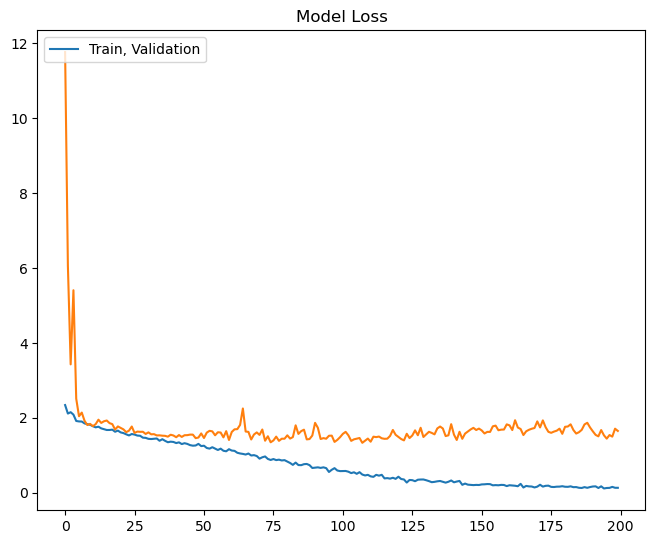

In [144]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train, Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

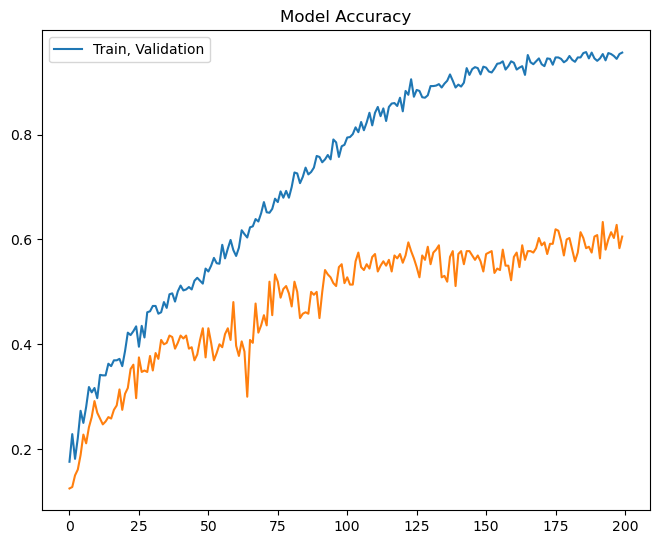

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train, Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

In [146]:
model_json = model.to_json()
with open("model_a1.json","w") as json_file:
    json_file.write(model_json)